# 2D slice CNN
2D slices are fed into the CNN. The slices are halfway though the x, y, and z axes.

In [1]:
from __future__ import print_function
import numpy as np
import dicom
import matplotlib.pyplot as plt
import os, glob
import tensorflow as tf
import tflearn
import sklearn
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interp
import datetime
%matplotlib inline

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


## Import and preprocess data

In [2]:
def importHeartData(calmFile, stressFile, ind):
    """
    Import heart data and extract the pixel array.
    Slice halfway along ind axis.
    Concatenate and return stress file and calm file.
    """
    calmTmp = dicom.read_file(calmFile).pixel_array
    stressTmp = dicom.read_file(stressFile).pixel_array
    
    calmTmp = cropHeart(calmTmp)
    stressTmp = cropHeart(stressTmp)
    
    # Slice halfway along ind axis
    if ind==0:
        calm2d = calmTmp[calmTmp.shape[ind]/2]
        stress2d = stressTmp[stressTmp.shape[ind]/2]
    if ind==1:
        calm2d = calmTmp[:,calmTmp.shape[ind]/2]
        stress2d = stressTmp[:,stressTmp.shape[ind]/2]
    if ind==2:
        calm2d = calmTmp[:,:,calmTmp.shape[ind]/2]
        stress2d = stressTmp[:,:,stressTmp.shape[ind]/2]
    
    # Normalise the 2d slices
    calm2d = sklearn.preprocessing.normalize(calm2d)
    stress2d = sklearn.preprocessing.normalize(stress2d)
    
    # Pad the 2d slices with zeros so that they are all the same size
    zeroArr0 = np.zeros((34,34))
    zeroArr1 = np.zeros((34,34))
    zeroArr0[:calm2d.shape[0],:calm2d.shape[1]] = calm2d
    zeroArr1[:stress2d.shape[0],:stress2d.shape[1]] = stress2d
    
    catOut = [zeroArr0, zeroArr1]
    return catOut

def importDir(parentDir):
    """
    Scan though directories in parent directory; look for dirs labelled 
    STRESS* or REST* in the imediate subsirs and import any dcm files in them.
    Return a dataFile of the concatenated stress and calm *.dcm files.
    """
    tmplst = []
    for dirs in os.listdir(parentDir):
        cwdStress = glob.glob(parentDir+"/"+dirs+"/STRESS*/*.dcm")
        cwdCalm = glob.glob(parentDir+"/"+dirs+"/REST*/*.dcm")
        # Get slices halfway along x, y, and z axes:
        xAx = importHeartData(cwdCalm[0], cwdStress[0], 0)
        yAx = importHeartData(cwdCalm[0], cwdStress[0], 1)
        zAx = importHeartData(cwdCalm[0], cwdStress[0], 2)
        tmplst.append(np.concatenate((xAx, yAx, zAx), axis=0))
        
    dataFile = np.array(tmplst)
    #print(dataFile.shape)
    
    return dataFile

def cropHeart(inp):
    """
    Crop the heart so that all the padding is done away with.
    Output cropped heart.
    """
    # argwhere will give you the coordinates of every non-zero point
    true_points = np.argwhere(inp)
    # take the smallest points and use them as the top left of your crop
    top_left = true_points.min(axis=0)
    # take the largest points and use them as the bottom right of your crop
    bottom_right = true_points.max(axis=0)
    out = inp[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
          top_left[1]:bottom_right[1]+1,   # inclusive
          top_left[2]:bottom_right[2]+1]  
    return out

In [3]:
# Do data import
normDir = "./data/nlst"
normDat = importDir(normDir)
abDir = "./data/rlst"
abDat = importDir(abDir)
inData = np.concatenate([normDat[:abDat.shape[0]], abDat]) # Normal and abnormal data same number of ppts

# Do labelling
normLab = np.zeros(normDat.shape[0])[:abDat.shape[0]]
abLab = np.ones(abDat.shape[0])
labels = np.concatenate([normLab, abLab])
    
# Mutual shuffle
shufData, shufLab = sklearn.utils.shuffle(inData, labels, random_state=1)
shufData = np.reshape(shufData,(-1,6,34,34,1))
shufLabOH = np.eye(2)[shufLab.astype(int)] # One hot encode

# k fold the data
k = 5
kfoldData = np.array_split(shufData, k)
kfoldLabelsOH = np.array_split(shufLabOH, k)
kfoldLabels = np.array_split(shufLab, k)
print(kfoldData[0].shape)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


(12, 6, 34, 34, 1)


## Visualise input data

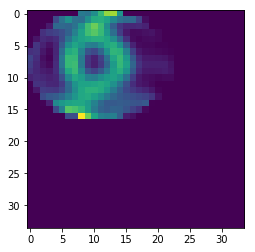

In [4]:
plt.imshow(shufData[10,0].reshape((34,34)))

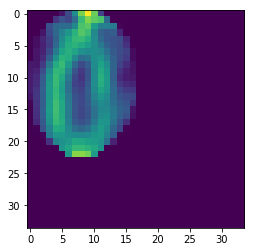

In [5]:
plt.imshow(shufData[10,4].reshape(34,34))

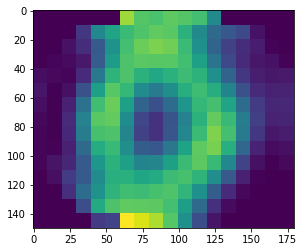

In [6]:
a = shufData[0,0,:15,:18].reshape(15,18)
n=10
plt.imshow(np.kron(a, np.ones((n,n))))

## Neural net

In [7]:
spec = []
sens = []
roc = []

In [8]:
for i in np.arange(0,k,1):
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net = tflearn.layers.core.input_data(shape=[None, 6, 34, 34, 1])

    # First layer:
    net = tflearn.layers.conv.conv_3d(net, 16, [6,10,10],  activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

    # Second layer:
    net = tflearn.layers.conv.conv_3d(net, 32, [6,10,10], activation="leaky_relu")
    net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

    # Fully connected layer
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

    # Dropout layer:
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)

    # Output layer:
    net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

    net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')
    model = tflearn.DNN(net, tensorboard_verbose=0)
    
    # Train the model, leaving out the kfold not being used
    dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 6, 34, 34, 1])
    dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
    model.fit(dummyData, dummyLabels, batch_size=10, n_epoch=50, show_metric=True)
    
    # Get sensitivity and specificity
    illTest = []
    healthTest = []
    for index, item in enumerate(kfoldLabels[i]):
        if item == 1:
            illTest.append(kfoldData[i][index])
        if item == 0:
            healthTest.append(kfoldData[i][index])

    healthLabel = np.tile([1,0], (len(healthTest), 1))
    illLabel = np.tile([0,1], (len(illTest), 1))
    sens.append(model.evaluate(np.array(healthTest), healthLabel))
    spec.append(model.evaluate(np.array(illTest), illLabel))

    # Get roc curve data
    predicted = np.array(model.predict(np.array(kfoldData[i])))
    fpr, tpr, th = roc_curve(kfoldLabels[i], predicted[:,1])
    auc = roc_auc_score(kfoldLabels, predicted[:,1])
    roc.append([fpr, tpr, auc])

Training Step: 249  | total loss: 0.30333 | time: 20.830s
| Adam | epoch: 050 | loss: 0.30333 - acc: 0.9286 -- iter: 40/47
Training Step: 250  | total loss: 0.27728 | time: 26.422s
| Adam | epoch: 050 | loss: 0.27728 - acc: 0.9358 -- iter: 47/47
--


## Postprocessing (specificity, sensitivity, roc curves)

In [9]:
print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens))

Specificity: [[0.625], [0.0], [0.66666668653488159], [0.40000000596046448], [0.5]] 
Avg: 0.438333338499 
Sensitivity: [[0.75], [0.5], [0.0], [0.66666668653488159], [0.55555558204650879]] 
Avg: 0.494444453716


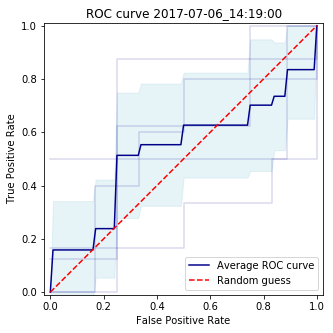

In [10]:
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

plt.figure(figsize=(5, 5))

tprs = []
base_fpr = np.linspace(0, 1, 101)

for i in np.arange(k):
    fpr = roc[i][0]
    tpr = roc[i][1]
    plt.plot(fpr, tpr, alpha=0.15, color="darkblue")
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, color="darkblue", label="Average ROC curve")
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--', label="Random guess")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve '+dt)
plt.legend(loc=4)
plt.axes().set_aspect('equal', 'datalim')
plt.savefig("./figures/rocCurves/"+dt+"-2dsliceCNN.png")